In [1]:
import spotify
import utils

sp = spotify.login(scope='playlist-modify-private')
user = sp.current_user()
username = user['id']
displayName = user['display_name']
displayName

'Mehmet Birgi'

In [2]:
# get all categories 
results = sp.categories(country='CH')['categories']
categories = results['items']
while results['next']:
    results = sp.next(results)['categories']
    categories.extend(results['items'])
print(f"{len(categories)} categories found")

37 categories found


In [3]:
[(ctg['id'], ctg['name']) for ctg in categories]

[('toplists', 'Top Lists'),
 ('at_home', 'At Home'),
 ('hiphop', 'Hip-Hop'),
 ('pop', 'Pop'),
 ('mood', 'Mood'),
 ('french_variety', 'French Pop'),
 ('party', 'Party'),
 ('edm_dance', 'Electronic/Dance'),
 ('rock', 'Rock'),
 ('chill', 'Chill'),
 ('wellness', 'Wellness'),
 ('workout', 'Workout'),
 ('indie_alt', 'Indie'),
 ('decades', 'Decades'),
 ('focus', 'Focus'),
 ('rnb', 'R&B'),
 ('thirdparty', 'Tastemakers'),
 ('sleep', 'Sleep'),
 ('latin', 'Latin'),
 ('jazz', 'Jazz'),
 ('classical', 'Classical'),
 ('audiobooks', 'Audiobooks'),
 ('country', 'Country'),
 ('romance', 'Romance'),
 ('dinner', 'Cooking & Dining'),
 ('family', 'Kids & Family'),
 ('metal', 'Metal'),
 ('roots', 'Folk & Acoustic'),
 ('popculture', 'Trending'),
 ('gaming', 'Gaming'),
 ('travel', 'Travel'),
 ('soul', 'Soul'),
 ('punk', 'Punk'),
 ('reggae', 'Reggae'),
 ('blues', 'Blues'),
 ('funk', 'Funk'),
 ('arab', 'Arab')]

In [4]:
selected_category_ids = [
    'edm_dance',
    'rock',
    'indie_alt',
    'latin',
    'jazz',
    'soul',
    'country',
    'reggae',
    'blues',
    'funk',
]

In [12]:
playlists = []
for cat_id in selected_category_ids:
    results = sp.category_playlists(cat_id)['playlists']
    newpls = [{'category': cat_id, 'name': pl['name'], 'id': pl['id']} for pl in results['items']]
    playlists.extend(newpls)
    print(f"added {len(newpls)} playlists for category {cat_id}")
    while results['next']:
        results = sp.next(results)['playlists']
        newpls = [{'category': cat_id, 'name': pl['name'], 'id': pl['id']} for pl in results['items']]
        playlists.extend(newpls)
        print(f"added {len(newpls)} playlists for category {cat_id}")
# dedupe list
print(len(playlists))
playlists = [dict(t) for t in {tuple(d.items()) for d in playlists}]
print(len(playlists))

added 20 playlists for category edm_dance
added 20 playlists for category edm_dance
added 20 playlists for category edm_dance
added 6 playlists for category edm_dance
added 20 playlists for category rock
added 20 playlists for category rock
added 20 playlists for category rock
added 6 playlists for category rock
added 20 playlists for category indie_alt
added 19 playlists for category indie_alt
added 20 playlists for category latin
added 20 playlists for category latin
added 20 playlists for category latin
added 19 playlists for category latin
added 20 playlists for category jazz
added 8 playlists for category jazz
added 20 playlists for category soul
added 5 playlists for category soul
added 20 playlists for category country
added 20 playlists for category country
added 7 playlists for category country
added 20 playlists for category reggae
added 20 playlists for category blues
added 13 playlists for category funk
403
403


In [13]:
playlists[1]

{'category': 'country', 'name': 'Wild Country', 'id': '37i9dQZF1DX5mB2C8gBeUM'}

In [16]:
import ipypb
tracks = []
for playlist in ipypb.track(playlists):
    results = sp.playlist(playlist['id'])['tracks']
    for item in results['items']:
        if item['track']:
            tracks.append({
                'id': item['track']['id'],
                'name': item['track']['name'],
                'artists': [{'id': artist['id'], 'name': artist['name']} for artist in item['track']['artists']],
                'playlist': playlist
            })
    while results['next']:
        results = sp.next(results)
        for item in results['items']:
            if item['track']:
                tracks.append({
                    'id': item['track']['id'],
                    'name': item['track']['name'],
                    'artists': [{'id': artist['id'], 'name': artist['name']} for artist in item['track']['artists']],
                    'playlist': playlist
                })
len(tracks)

 [████████████████████████████████████████████████████████████] 403/403 [00:53<00:00, 0.13s/it]

31372

In [17]:
tracks[0]

{'id': '7zwwvrJAWGjfc9wFD3bVzZ',
 'name': 'Cupid De Locke - Remastered 2012',
 'artists': [{'id': '40Yq4vzPs9VNUrIBG5Jr2i',
   'name': 'The Smashing Pumpkins'}],
 'playlist': {'category': 'rock',
  'name': 'Rock Love Songs',
  'id': '37i9dQZF1DX7Z7kYpKKGTc'}}

In [18]:
# dedupe tracks
unique_tracks = []
track_ids = set()
for index, track in enumerate(tracks):
    if track['id'] not in track_ids:
        unique_tracks.append(track)
        track_ids.add(track['id'])
len(unique_tracks)

26268

In [21]:
# get audio features
batch_size = 50
features = []
track_ids = list(track_ids)
for i in ipypb.track(range(0, len(track_ids), batch_size)):
    results = sp.audio_features(track_ids[i:i+batch_size])
    features.extend(results)

 [████████████████████████████████████████████████████████████] 526/526 [00:49<00:00, 0.09s/it]

In [22]:
import pandas as pd
df_audio_features = pd.DataFrame(features).drop(
    ['track_href', 'analysis_url', 'type', 'uri', 'loudness'], axis=1)
df_audio_features

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.505,0.911,10,0,0.0624,0.031500,0.000018,0.0745,0.281,81.978,3lCfyDeaEYxEvJSnhv1ek3,236283,4
1,0.615,0.969,5,1,0.0383,0.348000,0.000002,0.1350,0.950,174.927,0j8PJyGPOaLJZyWIxw5MjN,360784,4
2,0.307,0.635,7,1,0.0339,0.015500,0.004860,0.3660,0.305,166.978,2IZZqH4K02UIYg5EohpNHF,306427,4
3,0.779,0.794,9,1,0.0360,0.339000,0.000002,0.1350,0.725,129.073,3VwFVdzHS7kEC0XKswiWA9,236253,4
4,0.186,0.546,2,1,0.0373,0.451000,0.000000,0.2010,0.533,177.526,6QZfj7u76JcewmSARFVUmr,152453,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26263,0.623,0.747,0,1,0.0261,0.130000,0.419000,0.1060,0.398,109.963,2OvQx1RIx6Ymys51lH87xJ,270028,4
26264,0.509,0.405,2,0,0.0360,0.319000,0.005900,0.1230,0.274,141.509,3waUNDqqEcv8GFLr6w3YNz,215947,3
26265,0.521,0.888,4,0,0.0443,0.002470,0.001080,0.1150,0.115,125.986,0NA3qmF7whDKExwYa6V7WD,220476,4
26266,0.294,0.970,4,1,0.2650,0.000706,0.000000,0.1230,0.144,166.475,4KliQFRlvNKnlVYzMMbSMq,234707,4


In [23]:
# save tracks
import json
import os
folder = 'data'
filename = 'spotify_selected_categories_tracks.json'
if not os.path.exists(folder):
    os.mkdir(folder)
with open(os.path.join(folder, filename), 'w', encoding='utf-8') as f:
    df_audio_features.to_json(path_or_buf=f, orient='records', indent=4)

##### read the file

In [24]:
import json
import os
folder = 'data'
filename = 'spotify_selected_categories_tracks.json'
with open(os.path.join(folder, filename), 'r', encoding='utf-8') as f:
    tracks = json.load(f)
len(tracks)

26268

##### select the suitable tracks:

In [46]:
tempo_min, tempo_max = 110, 115
track_ids = list(df_audio_features[
    (df_audio_features['tempo'] >= tempo_min) & 
    (df_audio_features['tempo'] <= tempo_max) & 
    (df_audio_features['danceability'] >= 0.85) &
    (df_audio_features['liveness'] <= 0.4) &
    (df_audio_features['speechiness'] <= 0.33)
]['id'])
len(track_ids)

125

In [47]:
playlist_id, is_new = spotify.get_playlist_by_name(sp, 
        f"BPM {tempo_min} - {tempo_max} (Spotify Categories)", 
        create_if_none=True)
if playlist_id and is_new:
    print(f"Created new playlist with ID {playlist_id}")
elif playlist_id:
    print(f"Found existing playlist with ID {playlist_id}")
else:
    print("Something went wrong :-(")

Created new playlist with ID 3PZfQ2NkbDDTEFjjnNMqmZ


In [48]:
sp.user_playlist_change_details(user['id'], playlist_id, public=False,
                                description=f"Categories: {selected_category_ids}")

In [49]:
# add tracks to playlist
spotify.add_tracks(sp, playlist_id, track_ids, skip_duplicates=True)

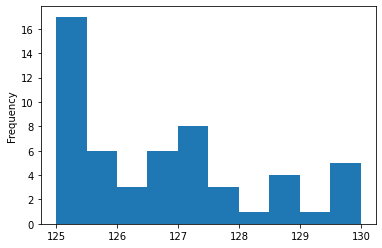

In [17]:
max_ids = 50
tracks_audio_features = []
for i in range(0, len(track_ids), max_ids):
    results = sp.audio_features(track_ids[i:i+max_ids])
    tracks_audio_features.extend(results)
len(tracks_audio_features)
df_audio_features = pd.DataFrame(tracks_audio_features)
df_audio_features['tempo'].plot.hist()